In [2]:
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import math
from ChK.ChK_analysis import list_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
warnings.filterwarnings('ignore')

### Functions

In [3]:
def unique_group_hist(data, column, figsize=(7, 4), filter_par = None , filter_val = None):
    
    if filter_par is not None:
        data = data[data[filter_par] == filter_val]
    unique_group = data[column].unique()
    unique_group, len(unique_group)
    
    group_count = {}
    total_counts = 0
    for group in unique_group:
        group_mask = data[column] == group
        group_count[group] = sum(group_mask)
        total_counts = total_counts + sum(group_mask)
    group_count, total_counts
    
    fig, ax = plt.subplots(figsize=figsize)  # Create figure and axes
    ax.barh(list(group_count.keys()), list(group_count.values()), color='teal', alpha=0.5)

    # Set titles and labels using ax
    ax.set_title(f'Counts of Human Neurons per {column}')
    ax.set_xlabel('Counts')  # For horizontal bar plot, this is the count
    ax.set_ylabel(f'{column}')  # group on the y-axis

    # Add a grid along the x-axis
    ax.grid(color='black', alpha=0.07, axis='x')

    # Optional: Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()
    return group_count

In [4]:
def plot_mean_current_clusters(data, dict_subclass, cols_volt, subclass_name):
    """Takes the dictionary of unique clusters within a subclass (created previously with
    unique_group_hist() and plots the current-voltage for those clusters.)

    Args:
        data(dataframe): dataframe to filter and plot.
        dict_subclass (dictionary): keys are unique clusters and values the count of cells for each cluster.
        cols_volt (_type_): _description_
        subclass_name (_type_): _description_
    """
    color_list = list_colors(len(dict_subclass.keys()))
    color_dict = {group: color_list[index] for index, group in enumerate(dict_subclass.keys())}
    
    fig, ax = plt.subplots(figsize=(8, 4))
    group = 'SEAAD_cluster_label.assignment'
    
    # Variables
    v_steps = [-50, -35, -20, -5, 10, 25, 40, 55, 70]
    cols_dict = {
        'total' : ['tot_-50', 'tot_-35', 'tot_-20', 'tot_-5', 'tot_10',
                'tot_25', 'tot_40', 'tot_55', 'tot_70'],
        'fast' : ['fast_-50', 'fast_-35', 'fast_-20', 'fast_-5', 'fast_10',
                'fast_25', 'fast_40', 'fast_55', 'fast_70'],
        'non_fast' : ['nonfast_-50','nonfast_-35','nonfast_-20','nonfast_-5',
                'nonfast_10','nonfast_25', 'nonfast_40','nonfast_55','nonfast_70'],
        'slow' : [ 'slow_-50', 'slow_-35','slow_-20','slow_-5', 'slow_10', 'slow_25',
                'slow_40', 'slow_55', 'slow_70']
    }
    
    name_plot = cols_volt
    cols_volt = cols_dict[cols_volt]

    mean_std_curr_subcls = {}
    handles=[]
    
    for cluster in dict_subclass.keys():
        df_human_subcls = data.copy()
        df_human_subcls_c = df_human_subcls[df_human_subcls[group]==cluster]
        df_human_subcls_c = df_human_subcls_c.reset_index(drop=True)
        n_cells = df_human_subcls_c.shape[0]

        # Mean and std for each cluster
        mean_std_curr_subcls[cluster] = [np.mean(df_human_subcls_c, axis=0),
                                        np.std(df_human_subcls_c, axis=0),
                                        n_cells] 
        
        handles.append(Line2D([0], [0], color=color_dict[cluster], marker='o',
                        markersize=4, linestyle='-', label=f'{cluster}',
                        alpha=0.7))
        
        for cell in range(n_cells):
            values_current = []
            
            for index, voltage in enumerate(v_steps):
                ax.scatter(voltage, df_human_subcls_c[cols_volt[index]][cell],
                           color=color_dict[cluster], s=6)
                values_current.append(df_human_subcls_c[cols_volt[index]][cell])
                
            plt.plot(v_steps, values_current, color=color_dict[cluster], alpha=0.7,
                     label=cluster, linewidth=1)
            
    # Grid and axes lines of the main plot
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    plt.ylabel(f'{name_plot} current (pA)')
    plt.xlabel('Voltage (mV)')
    plt.title(f'{name_plot} current for {subclass_name} cells')

    plt.legend(handles=handles, ncol=4)
    plt.tight_layout()
    plt.show()
    
    ######
    
    fig, ax = plt.subplots(figsize=(8,4))
    for cluster in dict_subclass.keys():
        mean_current_sub = []
        std_current_sub = []
        for index, voltage in enumerate(v_steps):
            plt.scatter(voltage, mean_std_curr_subcls[cluster][0][cols_volt[index]], color=color_dict[cluster])
            mean_current_sub.append(mean_std_curr_subcls[cluster][0][cols_volt[index]])
            std_current_sub.append(mean_std_curr_subcls[cluster][1][cols_volt[index]])
        plt.plot(v_steps, mean_current_sub,color=color_dict[cluster],
                label=f"{cluster} (n = {mean_std_curr_subcls[cluster][2]})")
        
        mean_current_sub = np.array(mean_current_sub)
        std_current_sub = np.array(std_current_sub)
        plt.fill_between(v_steps, mean_current_sub-std_current_sub, mean_current_sub+std_current_sub,
                        color=color_dict[cluster], alpha=0.1)
        
    plt.title(f'Mean $\pm$ std {name_plot} current for {subclass_name} clusters')
    plt.xlabel('Voltage')
    plt.ylabel(f'Mean {name_plot} current (pA)')
    plt.legend(ncol=2)
    plt.savefig(f'../results/peak_current_H/mean_{name_plot}_current_{subclass_name}_H.png', dpi=300)
    plt.show()
            

In [5]:
# Read only sheet 'inact_recov' from 'channel_data_densities.xlsx'
df_all = pd.read_excel('../data/channel_data_densities.xlsx', sheet_name = 'peak_current_densities')
df_all.head(3)

,cell,tot_-50,tot_-35,tot_-20,tot_-5,tot_10,tot_25,tot_40,tot_55,tot_70,...,nonfast_50,nonfast_-120,nonfast_-105,nonfast_-90,nonfast_-75,nonfast_-60,nonfast_-45,nonfast_-30,nonfast_-15,nonfast_0
0,Ctgf-T2A-dgCre;Ai14-496566.03.01.01,0.074444,0.267532,0.695577,1.305129,2.002863,2.399162,2.781400,3.511871,3.651309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Rbp4-Cre_KL100;Ai14-658999.10.09.02,0.075074,0.409873,0.884221,2.591192,5.079291,7.254366,8.914043,10.394306,11.251162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ctgf-T2A-dgCre;Ai14-509689.04.02.01,0.184972,0.169915,0.382888,NaN,1.385268,1.760363,2.174393,2.209563,2.581076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Merge datasets

In [6]:
# Read human ttype dataset
human_ttypes = pd.read_csv('../data/SEAAD_240904_MMC_HANN_rsc369.csv')  #locked_jeremys_data_SEAAD_240822.csv or SEAAD_240904_MMC_HANN_rsc369.csv
human_ttypes.head(3)

,seq-name,cell_id,patched_cell_container_label,cell_name_label,batch_vendor_name_label,SEAAD_class_label.assignment,SEAAD_class_label.bootstrapping_probability,SEAAD_class_label.avg_correlation,SEAAD_subclass_label.assignment,SEAAD_subclass_label.bootstrapping_probability,...,Tree_second_KL,seuratQCpass,UMAP_x,UMAP_y,class_MapMyCells,class_MapMyCells_softmax_probability,subclass_MapMyCells,subclass_MapMyCells_softmax_probability,supertype_MapMyCells,supertype_MapMyCells_softmax_probability
0,SM-GE62S_S097_E1-50,616836450,P2S4_170906_051_A01,H17.03.012.11.16.01,RSC-122,Neuronal: GABAergic,1.00,0.295518,Vip,0.96,...,7.749679,False,0.408320,0.714792,Non-neuronal and Non-neural,0.9954,Astrocyte,0.992,Astro_2,0.992
1,SM-GE62S_S098_E1-50,616840597,P2S4_170906_052_A01,H17.03.012.11.16.02,RSC-122,Neuronal: GABAergic,0.99,0.197187,Pvalb,0.82,...,4.700320,False,-0.060571,1.742508,Neuronal: GABAergic,0.9999,Pvalb,0.9996,Pvalb_15,0.9996
2,SM-GE62S_S099_E1-50,616858807,P2S4_170906_053_A01,H17.03.012.11.16.03,RSC-122,Neuronal: GABAergic,1.00,0.274666,Pvalb,0.79,...,9.394618,False,-0.021292,1.271244,Neuronal: Glutamatergic,0.9652,L5 IT,0.8265,L5 IT_7,0.8265


In [7]:
# Merge data files by 'jem-id_patched_cell_container' & 'Sample ID'
df_human = pd.merge(left = df_all, left_on = 'cell',
            right = human_ttypes, right_on = 'cell_name_label', how = 'inner')

df_human.sort_values('cell');
df_human.shape

(269, 177)

#### Plotting data by subclass

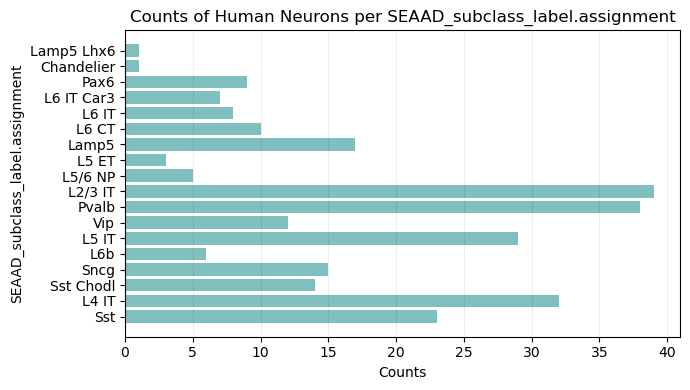

In [8]:
unique_group_hist(df_human, column = 'SEAAD_subclass_label.assignment');

#### Plotting data by class

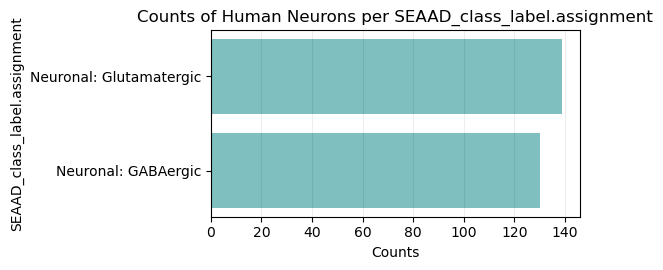

In [9]:
unique_group_hist(df_human, column='SEAAD_class_label.assignment', figsize=(6, 2.8));

#### Plotting data by cluster

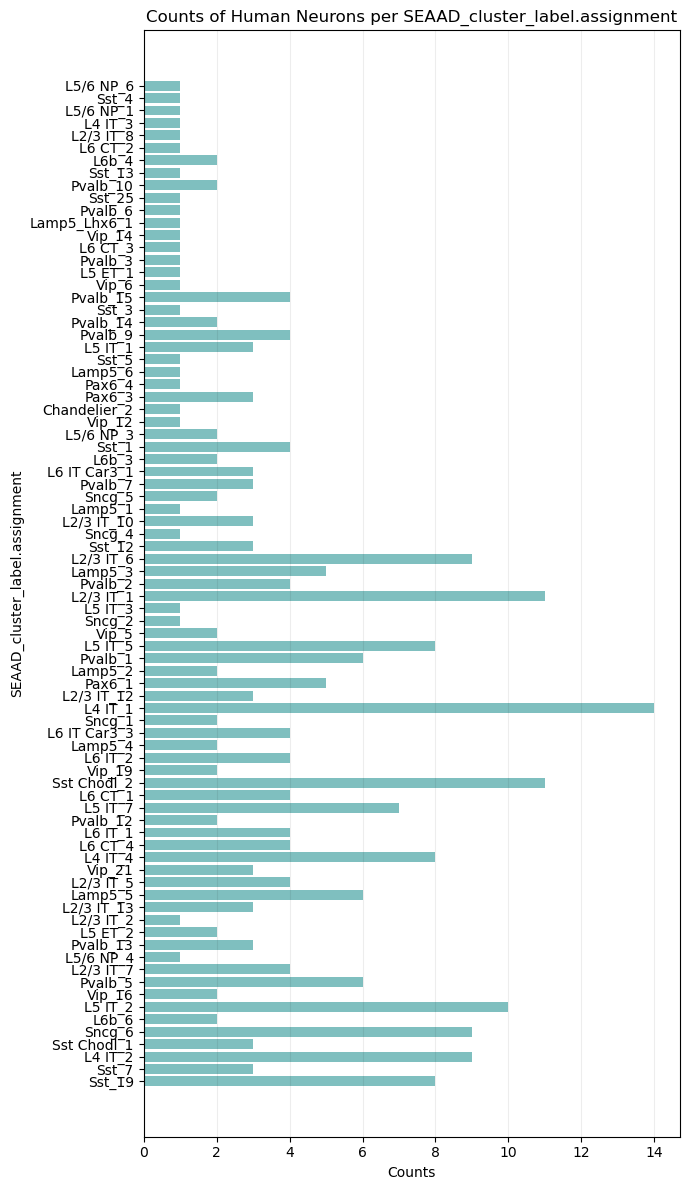

{'Sst_19': 8,
 'Sst_7': 3,
 'L4 IT_2': 9,
 'Sst Chodl_1': 3,
 'Sncg_6': 9,
 'L6b_6': 2,
 'L5 IT_2': 10,
 'Vip_16': 2,
 'Pvalb_5': 6,
 'L2/3 IT_7': 4,
 'L5/6 NP_4': 1,
 'Pvalb_13': 3,
 'L5 ET_2': 2,
 'L2/3 IT_2': 1,
 'L2/3 IT_13': 3,
 'Lamp5_5': 6,
 'L2/3 IT_5': 4,
 'Vip_21': 3,
 'L4 IT_4': 8,
 'L6 CT_4': 4,
 'L6 IT_1': 4,
 'Pvalb_12': 2,
 'L5 IT_7': 7,
 'L6 CT_1': 4,
 'Sst Chodl_2': 11,
 'Vip_19': 2,
 'L6 IT_2': 4,
 'Lamp5_4': 2,
 'L6 IT Car3_3': 4,
 'Sncg_1': 2,
 'L4 IT_1': 14,
 'L2/3 IT_12': 3,
 'Pax6_1': 5,
 'Lamp5_2': 2,
 'Pvalb_1': 6,
 'L5 IT_5': 8,
 'Vip_5': 2,
 'Sncg_2': 1,
 'L5 IT_3': 1,
 'L2/3 IT_1': 11,
 'Pvalb_2': 4,
 'Lamp5_3': 5,
 'L2/3 IT_6': 9,
 'Sst_12': 3,
 'Sncg_4': 1,
 'L2/3 IT_10': 3,
 'Lamp5_1': 1,
 'Sncg_5': 2,
 'Pvalb_7': 3,
 'L6 IT Car3_1': 3,
 'L6b_3': 2,
 'Sst_1': 4,
 'L5/6 NP_3': 2,
 'Vip_12': 1,
 'Chandelier_2': 1,
 'Pax6_3': 3,
 'Pax6_4': 1,
 'Lamp5_6': 1,
 'Sst_5': 1,
 'L5 IT_1': 3,
 'Pvalb_9': 4,
 'Pvalb_14': 2,
 'Sst_3': 1,
 'Pvalb_15': 4,
 'Vip_6': 1,
 

In [10]:
unique_group_hist(df_human, column='SEAAD_cluster_label.assignment', figsize=(7, 12))

## Plotting Currents for some subclasses

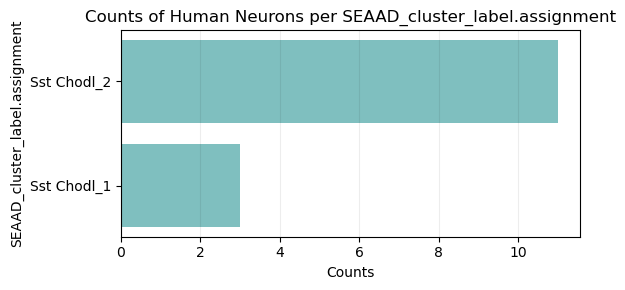

In [11]:
sst_chodl_count = unique_group_hist(df_human, column='SEAAD_cluster_label.assignment', figsize=(6, 3),
                  filter_par='SEAAD_subclass_label.assignment', filter_val='Sst Chodl')

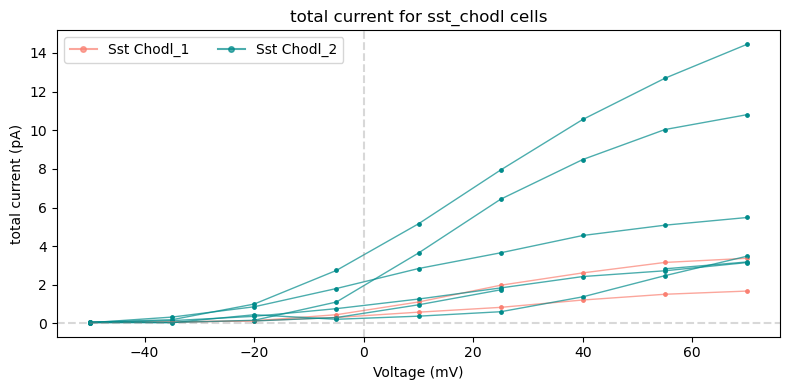

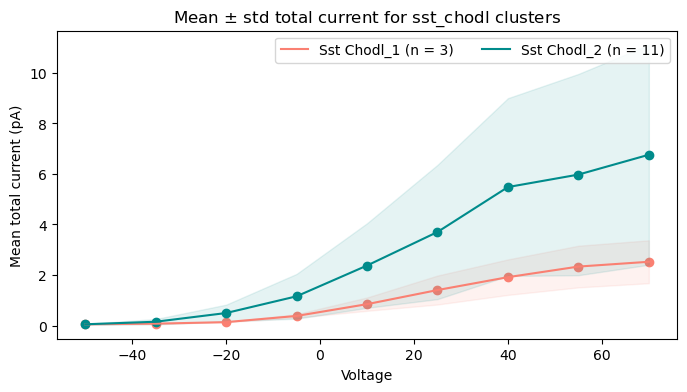

In [12]:
plot_mean_current_clusters(data = df_human, dict_subclass=sst_chodl_count, cols_volt='total', subclass_name='sst_chodl')

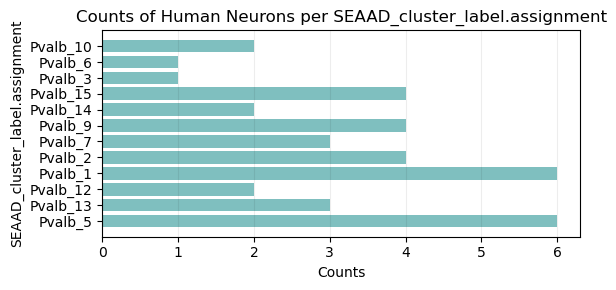

In [13]:
pvalb_count = unique_group_hist(df_human, column='SEAAD_cluster_label.assignment', figsize=(6, 3),
                  filter_par='SEAAD_subclass_label.assignment', filter_val='Pvalb')

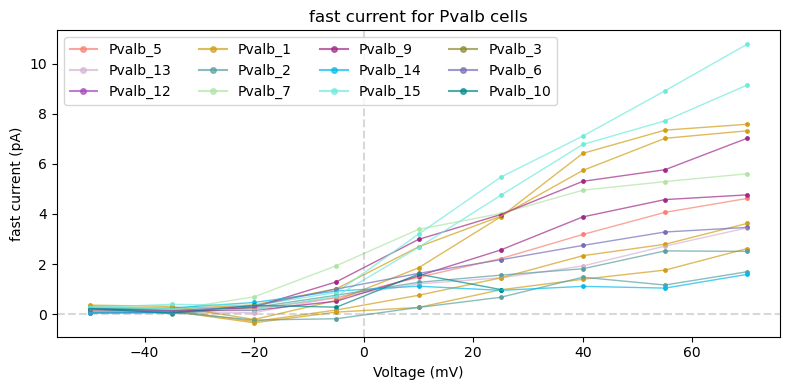

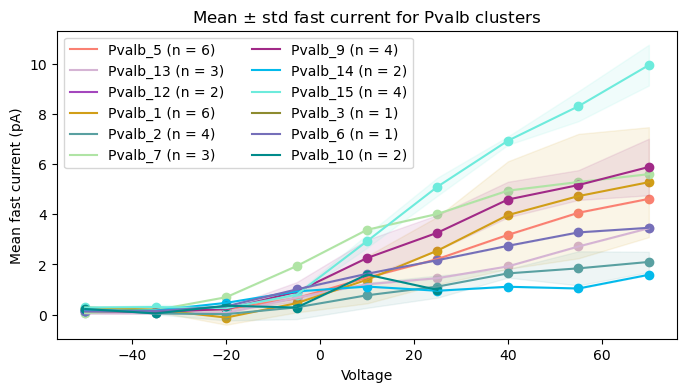

In [14]:
plot_mean_current_clusters(data = df_human, dict_subclass=pvalb_count, cols_volt='fast', subclass_name='Pvalb')

#### L4 IT subclass which has 4 clusters, two high current and two low current

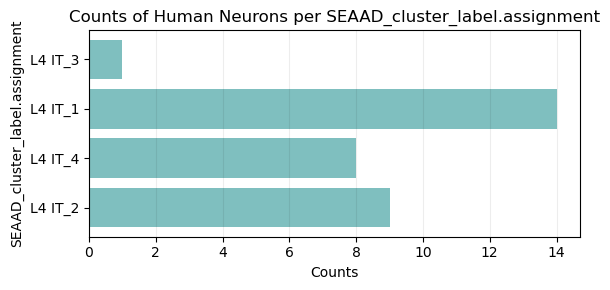

In [15]:
L4_IT_count = unique_group_hist(df_human, column='SEAAD_cluster_label.assignment', figsize=(6, 3),
                  filter_par='SEAAD_subclass_label.assignment', filter_val='L4 IT')


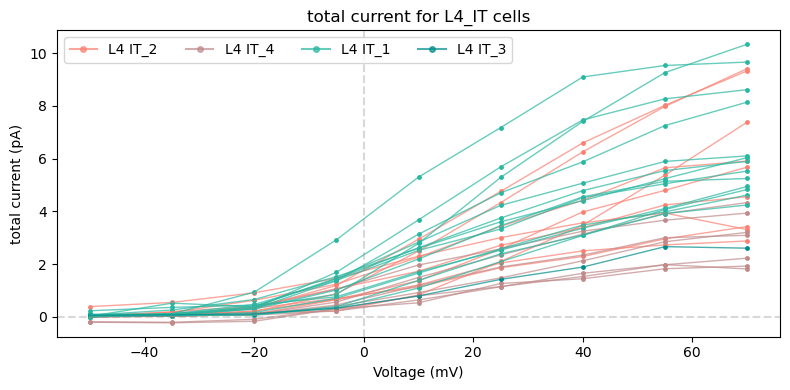

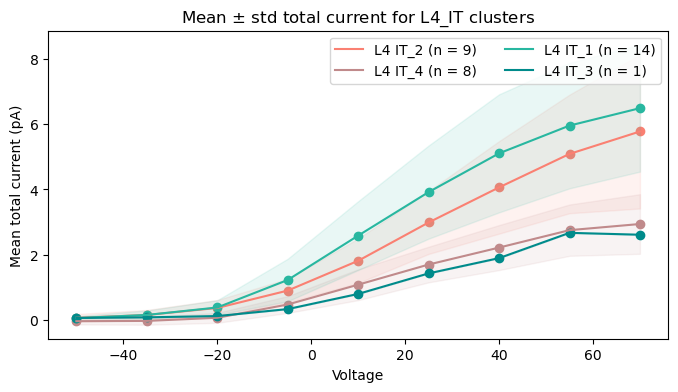

In [16]:
plot_mean_current_clusters(data = df_human, dict_subclass=L4_IT_count, cols_volt='total', subclass_name='L4_IT')

As expected for L4 IT there are 2 with high current (2 and 1) and two with low current (4 and 3), although 3 only has one data point. Plotting now mean. 

# Merge to have AP features.

#### More v-c curves

In [17]:
n_cells = 10
colors = list_colors(n_cells)

In [18]:
type(colors[0])

tuple

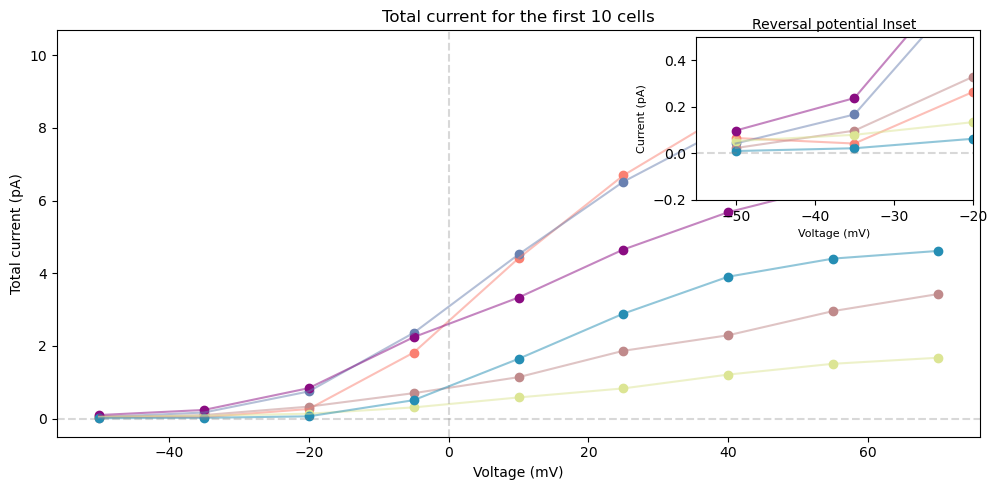

In [19]:
# Example of your given variables
v_steps = [-50, -35, -20, -5, 10, 25, 40, 55, 70]
cols_tot = ['tot_-50', 'tot_-35', 'tot_-20', 'tot_-5', 'tot_10', 'tot_25', 'tot_40', 'tot_55', 'tot_70']

conductances = {}

# Create the main figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Main plot for all cells
for cell in range(n_cells):
    values_current = []
    for index, voltage in enumerate(v_steps):
        ax.scatter(voltage, df_human[cols_tot[index]][cell], color=colors[cell])
        values_current.append(df_human[cols_tot[index]][cell])
    plt.plot(v_steps, values_current, color=colors[cell], alpha=0.5)

# Add a grid and axes lines to the main plot
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
plt.ylabel('Total current (pA)')
plt.xlabel('Voltage (mV)')
plt.title(f'Total current for the first {n_cells} cells')

# Add an inset axes inside the main plot
ax_inset = inset_axes(ax, width="30%", height="40%", loc='upper right')  # Adjust size and location

# Zoom into the specified rectangle for the inset plot (x=(-60, -20), y=(-1, 1))
for cell in range(n_cells):
    values_current_inset = []
    for index, voltage in enumerate(v_steps):
        if -60 <= voltage <= -20:
            ax_inset.scatter(voltage, df_human[cols_tot[index]][cell], color=colors[cell])
            values_current_inset.append(df_human[cols_tot[index]][cell])
    plt.plot([v for v in v_steps if -60 <= v <= -20], values_current_inset, color=colors[cell], alpha=0.5)

ax_inset.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
# Set the limits for the inset plot
ax_inset.set_xlim(-55, -20)
ax_inset.set_ylim(-0.2, 0.5)

# Add labels to the inset plot (optional)
ax_inset.set_title("Reversal potential Inset", fontsize=10)
ax_inset.set_xlabel('Voltage (mV)', fontsize=8)
ax_inset.set_ylabel('Current (pA)', fontsize=8)

# Show the final plot
plt.tight_layout()
plt.show()


### Plotting conductaces ???

In [20]:
# plt.figure(figsize=(10, 5))
# for cell in range(10): #df_all.shape[0]
#     plt.plot(v_steps, conductances[df_all['cell'][cell]])
# plt.ylabel('Conductace (pS)')
# plt.xlabel('Voltage (mV)')
# plt.title(f'Total current for the first {n_cells} cells') 

# #####################